In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

from scipy import stats
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

#### Reading and understanding the dataset

In [3]:
df = pd.read_csv('Emp_reimb.csv')
df.head(5)

,Year,Type_of_yr,Emp_ID,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,42865,92288.22,267.45,270.45,92826.12,12500.56,20703.20,7605.75,40809.51,133635.63
1,2015,Calendar,28253,1466.38,0.00,350.23,1816.61,442.03,3.00,141.59,586.62,2403.23
2,2018,Financial,30664,76536.95,10855.94,13586.72,100979.61,12464.61,18636.19,8011.41,39112.21,140091.82
3,2018,Financial,19482,45659.88,1625.37,3.00,47288.25,0.00,10084.20,3936.63,14020.83,61309.08
4,2017,Financial,7183,41832.00,0.00,6.00,41838.00,5908.52,7621.60,3254.50,16784.62,58622.62


In [4]:
df.shape

(49794, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49794 entries, 0 to 49793
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 49794 non-null  int64  
 1   Type_of_yr           49794 non-null  object 
 2   Emp_ID               49794 non-null  int64  
 3   Income               49794 non-null  float64
 4   Other_Income         49794 non-null  float64
 5   Overtime             49794 non-null  float64
 6   Total_Income         49794 non-null  float64
 7   Health_Insurance     49794 non-null  float64
 8   Retirement           49794 non-null  float64
 9   Other_Benefits       49794 non-null  float64
 10  Total_Benefits       49794 non-null  float64
 11  Total_Reimbursement  49794 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 4.6+ MB


From the above info, we see that "Type_of_yr" is only categorical and the other variables are numerical.

As per the data definition, "Year" is of categorical data type but here it got iterpreted as int64. Therefore, this will be converted to 'object' datatype. 

In [6]:
df['Year'] = df['Year'].astype('object')

In [7]:
df.dtypes

Year                    object
Type_of_yr              object
Emp_ID                   int64
Income                 float64
Other_Income           float64
Overtime               float64
Total_Income           float64
Health_Insurance       float64
Retirement             float64
Other_Benefits         float64
Total_Benefits         float64
Total_Reimbursement    float64
dtype: object

#### Remove insignificant variables

The variable Emp_ID has the details of employee ID numbers and hence it doesn't serve much use for further analysis. 

In [8]:
df = df.drop('Emp_ID', axis = 1)
df.head(3)

,Year,Type_of_yr,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,92288.22,267.45,270.45,92826.12,12500.56,20703.20,7605.75,40809.51,133635.63
1,2015,Calendar,1466.38,0.00,350.23,1816.61,442.03,3.00,141.59,586.62,2403.23
2,2018,Financial,76536.95,10855.94,13586.72,100979.61,12464.61,18636.19,8011.41,39112.21,140091.82


#### Outlier Treatment and Analysis

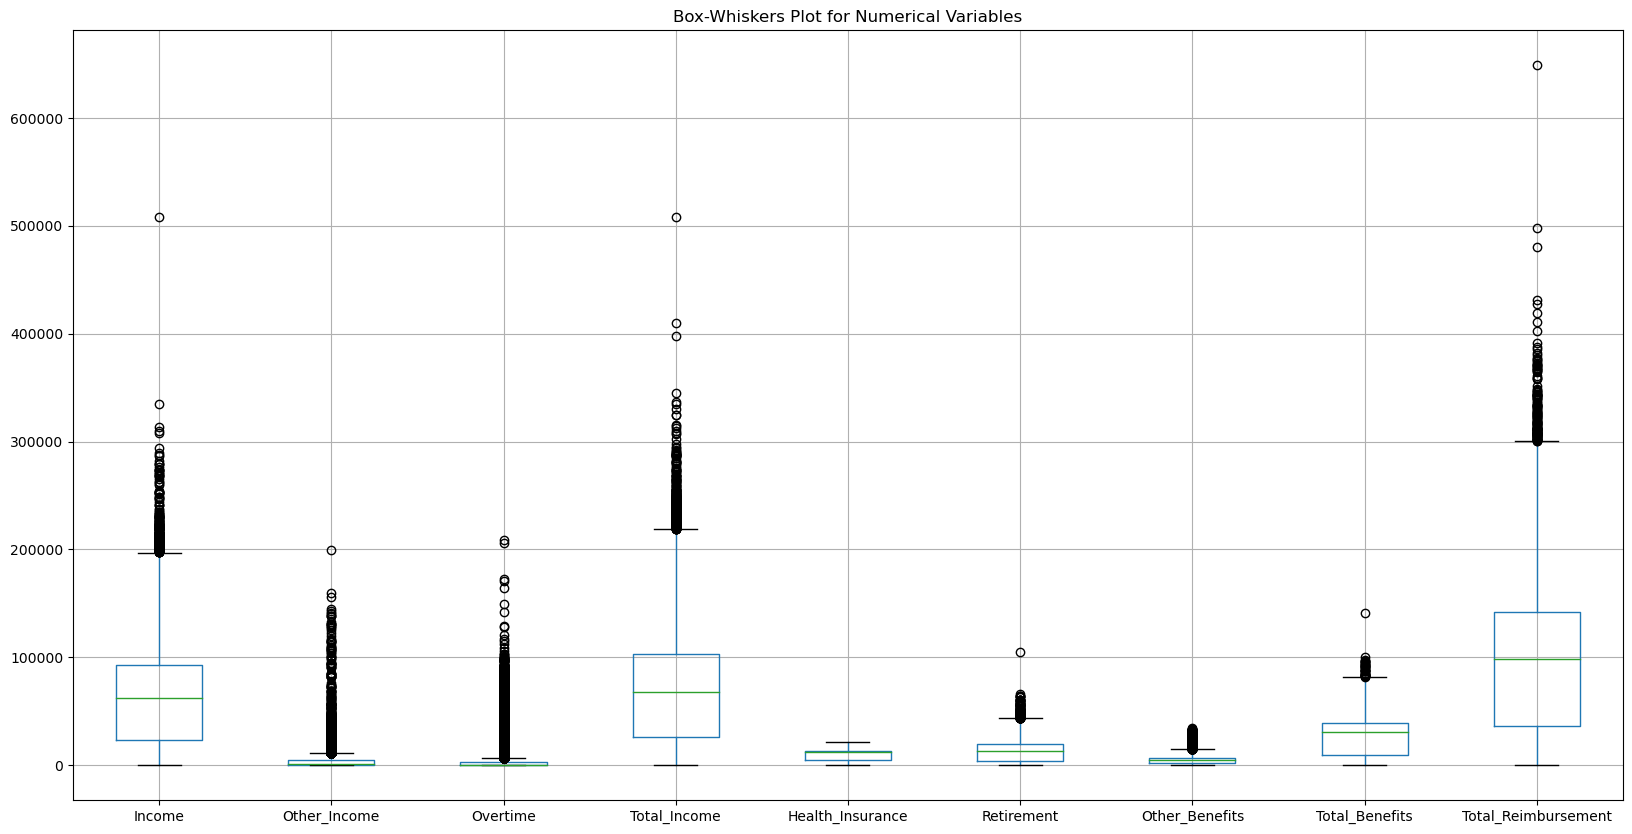

In [9]:
plt.figure(figsize = (20,10))
df.boxplot()
plt.title("Box-Whiskers Plot for Numerical Variables")
plt.xticks()
plt.show()

The variables Income, Total_income and Total_Reimbursement have a larger range of values as compared to other variables. Let's visualize the other variables once more without the former three to obtain the distribution of the later.

In [10]:
df.columns

Index(['Year', 'Type_of_yr', 'Income', 'Other_Income', 'Overtime',
       'Total_Income', 'Health_Insurance', 'Retirement', 'Other_Benefits',
       'Total_Benefits', 'Total_Reimbursement'],
      dtype='object')

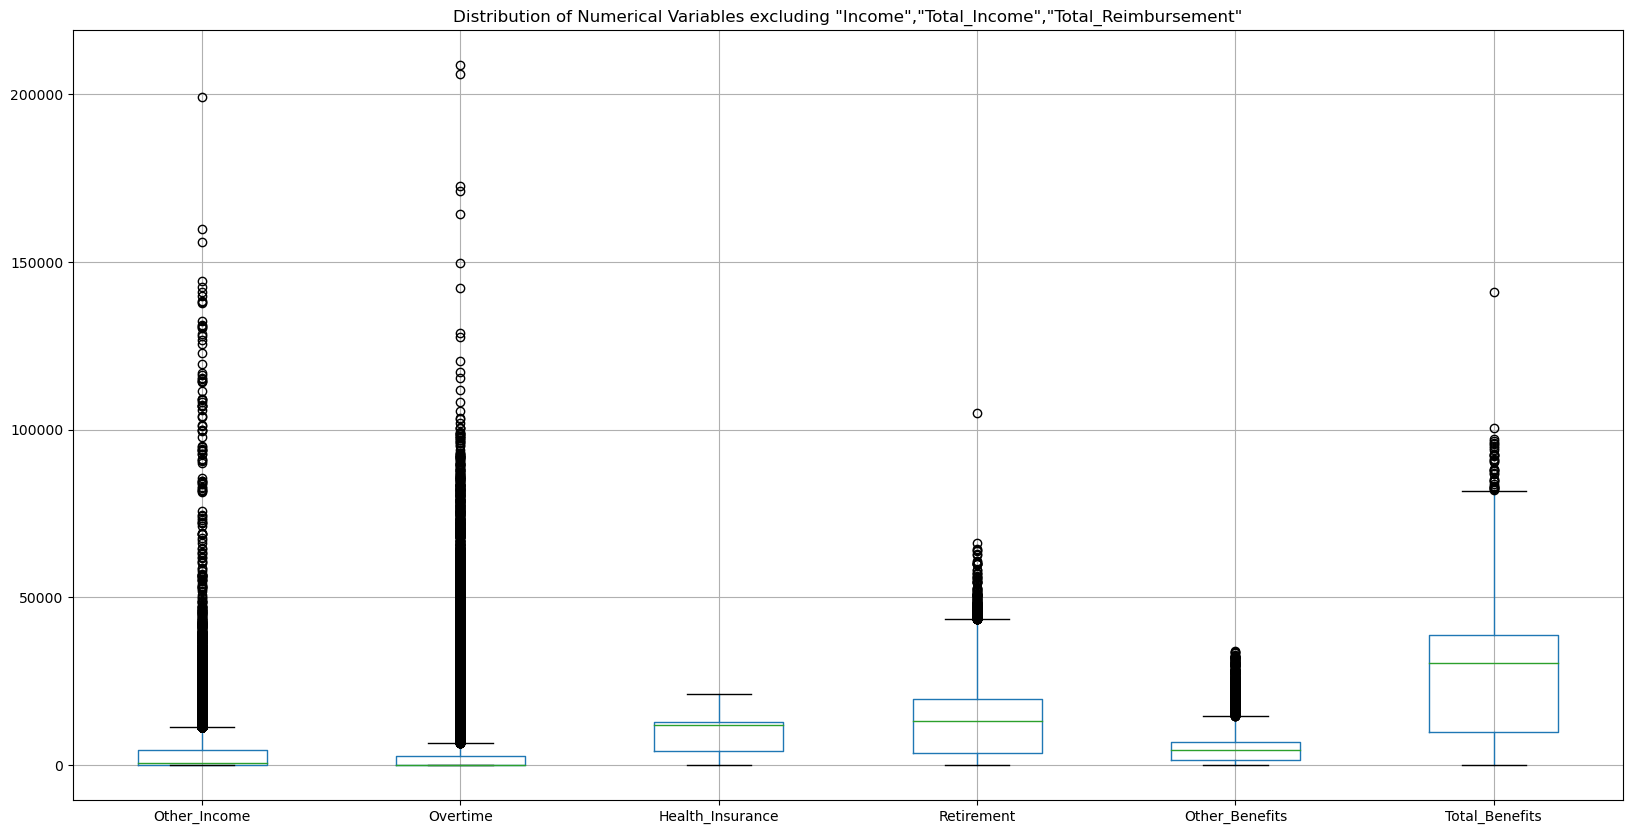

In [11]:
plt.figure(figsize = (20,10))
df.loc[:,['Other_Income', 'Overtime', 'Health_Insurance', 'Retirement', 'Other_Benefits', 'Total_Benefits']].boxplot()
plt.title('Distribution of Numerical Variables excluding "Income","Total_Income","Total_Reimbursement"')
plt.xticks()
plt.show()

Therefore, all variables except "Health_Insurance" have outliers. 

In [12]:
numeric_cols = list(df.dtypes[df.dtypes=='float64'].index)

In [13]:
# first quartile
q1 = df[numeric_cols].quantile(0.25)

# Third quantile
q3 = df[numeric_cols].quantile(0.75)

IQR = q3 - q1

df = df[~((df[numeric_cols] < (q1-1.5*IQR)) | (df[numeric_cols] > (q3+1.5*IQR))).any(axis=1)]
df.shape

(37601, 11)

#### Missing Values Analysis and Treatment

In [14]:
df.isnull().sum()

Year                   0
Type_of_yr             0
Income                 0
Other_Income           0
Overtime               0
Total_Income           0
Health_Insurance       0
Retirement             0
Other_Benefits         0
Total_Benefits         0
Total_Reimbursement    0
dtype: int64

There are no missing values

#### Scale Data

In [15]:
scale = StandardScaler()

In [16]:
df.iloc[:,2:] = scale.fit_transform(df.iloc[:,2:])

In [17]:
df

,Year,Type_of_yr,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
0,2015,Financial,0.979285,-0.476490,-0.234452,0.921936,0.911633,1.173979,1.141809,1.156404,0.996741
1,2015,Calendar,-1.259498,-0.588288,-0.175596,-1.270543,-1.504323,-1.186991,-1.269397,-1.374579,-1.312368
3,2018,Financial,-0.170116,0.091141,-0.431758,-0.175101,-1.592885,-0.037175,-0.043455,-0.529245,-0.275886
4,2017,Financial,-0.264475,-0.588288,-0.429544,-0.306401,-0.409098,-0.318048,-0.263809,-0.355337,-0.323156
5,2017,Calendar,0.531729,0.015084,-0.431020,0.506452,0.989326,0.506986,0.698634,0.726502,0.573061
...,...,...,...,...,...,...,...,...,...,...,...
49788,2015,Calendar,-1.032798,-0.560728,-0.430282,-1.055717,-0.961290,-1.186991,-1.031131,-1.157619,-1.094793
49790,2018,Financial,-1.251584,-0.588288,-0.428069,-1.271053,-1.480024,-1.186991,-1.268179,-1.366710,-1.310541
49791,2016,Financial,-0.394608,-0.588288,-0.430282,-0.433604,-0.219302,-0.411017,-0.322883,-0.358526,-0.416955
49792,2016,Financial,-0.137198,3.986109,-0.430282,0.081590,0.535788,-0.178629,0.205200,0.109694,0.090266


In [18]:
pd.DataFrame([np.round(df.iloc[:,2:].mean()),np.round(df.iloc[:,2:].std())],index=['Mean','Standard Deviation'])

,Income,Other_Income,Overtime,Total_Income,Health_Insurance,Retirement,Other_Benefits,Total_Benefits,Total_Reimbursement
Mean,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
Standard Deviation,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


As we can see above the mean is 0 and standard deviation is 1 which goes along with the standard normal distribution property of mean = 0 and standard deviation 1.

### Regression 101: Deep Dive

In [19]:
X = df['Total_Benefits']
y = df['Total_Reimbursement']

In [20]:
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size = 0.3, random_state = 1)
X_val,X_test,y_val,y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 1)

In [21]:
print("Train Set")
print("X Train",X_train.shape)
print("Y Train",y_train.shape)
print()
print("Validation Set")
print("X Validation Set",X_val.shape)
print("Y Validation Set",y_val.shape)
print()
print("Test Set") 
print("X Test Set",X_test.shape)
print("Y Test Set",y_test.shape)

Train Set
X Train (26320,)
Y Train (26320,)

Validation Set
X Validation Set (5640,)
Y Validation Set (5640,)

Test Set
X Test Set (5641,)
Y Test Set (5641,)


#### Build Simple Linear Regression Model using OLS

In [22]:
x_train_slr = pd.DataFrame(X_train)

c = np.ones(x_train_slr.shape[0])
# Another way to add constant to the Independent variable
# -> sm.add_constant(x_train_slr)

x_train_slr.insert(loc = 0,column = 'intercept', value = c)
x_train_slr.head()

,intercept,Total_Benefits
32437,1.0,-0.924075
27382,1.0,0.897168
26627,1.0,-1.355370
24073,1.0,0.797811
49495,1.0,1.041861


In [23]:
SLR_model = sm.OLS(y_train,x_train_slr).fit()
SLR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total_Reimbursement   R-squared:                       0.949
Model:                             OLS   Adj. R-squared:                  0.949
Method:                  Least Squares   F-statistic:                 4.848e+05
Date:                 Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                         20:27:01   Log-Likelihood:                 1661.4
No. Observations:                26320   AIC:                            -3319.
Df Residuals:                    26318   BIC:                            -3302.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       1.466e-05      0.001      0.010      0.992      -0.003       0.003
Total_Benefits     0.9744      0.001    696.263      0.000       0.972       0.977
==============================================================================
Omnibus:                    12064.055   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117016.449
Skew:                           1.965   Prob(JB):                         0.00
Kurtosis:                      12.553   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Predicting total_reimbursements using 'predict()' on training data
y_train_pred  = SLR_model.predict(x_train_slr)
display(y_train_pred.head())

32437   -0.900446
27382    0.874256
26627   -1.320718
24073    0.777437
49495    1.015250
dtype: float64

The R-Sqaured value 0.949 means the above model explains 94.9% of variation in Total_Reimbursement

Adjusted R-Sqaured  = 1-[((1-R^2) * (n-1))/(n-k-1)]

n: no. of data points

k: no. of independent variables/predictors.

n-1 helps scaling the (1-R^2) i.e. the unexplained variance.

n-k-1 acts as a the degrees of freedom which is no. of data points - no. of independent variables - 1(i.e. intercept) that helps adjust the scaled unexplained variance. It ultimately ensures that the measure of fit is not artificially inflated by adding more predictors. 

In [25]:
# Ho : Beta = 0 (All model parameters are 0 i.e. There is no significant effect of independent variables on the dependent variable)
# H1 : Beta <> 0 (Variables are significant)

print("F-Statistic:",SLR_model.fvalue)
print("Probability of F-Statistic for",SLR_model.pvalues)

F-Statistic: 484782.50714288984
Probability of F-Statistic for intercept         0.991647
Total_Benefits    0.000000
dtype: float64


As, p-value of F-Statistic is less than 0.05 we reject null hypothesis. Therefore, the independent variable has significant impact on the dependent variable.

Log-Likelihood:
* This measures the goodness of fit of the model. The higher the value of log-likelihood the better a model fits a dataset.

* The log-likelihood value for a given model can range between negative infinity to positive infinity.

* This is useful for comparing two or more models.

Limitations of Log-Likelihood:
* Adding more predictor variables to a model will almost always increase the log-likelihood value even if the additional predictor variables aren't statistically significant.

* This means we need to compare the log-likelihood values between two regression models if each model has the same number of predictor models.


AIC:

* Akaike Information Criterion used to compare relative quality of different statistical models for a given dataset.
* It provides a measure of how well a model fits the data while also penalizing models with too many parameters.
* AIC helps choos best models from a set of candidate.
* The formula includes a constant term "2k" that penalizes the model compleity.
* Formula: AIC = 2k + n * log(RSS/n)
* k is the number of parameters in the model.
* n is the sample size.
* RSS is the residual sum of squares.

BIC
* Bayesian Information Criterion is another metric used to compare the relative frequency of different statistical models.
* Like AIC, It balances the trade-off between a model's ability to fit the data and its complexity.
* However, BIC imposes a more severe penalty on models with mode parameters.
* It tends to favor simpler model even if they might not fit the data as well as more complex ones.
* The formula includes a term "k * log(n)" that increases the penalty for complexity as the sample size grows.
* Formula: BIC = k * log(n) + n * log(RSS/n)

Omnibus

* Omnibus test is carried out in order to check whether errors are normally distributed. Here, the null hypothesis is that errors are normally distributed.
* A value close to 0 is preferred and it indicates normalcy.

Prob (Omnibus)

* The Prob(Omnibus) performs a statistical test showing the probability that the residuals are normally distributed. Value is preferred to be close to 1.

**Here, from the output of Omnibus we conclude that residuals are normally distributed** 

Skewness
* Measures the degree of symmetry in the distribution.
* A distribution with 0 skewness is perfectly symmetrical, whereas a longer right tail is positively skewed and longer left tail is negatively skewed.

**Here, Skewness is 1.965 and that indicates the distribution is right skewed**

Kurtosis
* Measures proportion of data that is heavy-tailed or light-tailed in comparison to normal distriution.
* High kurtosis indicated sharp peak in the distribution's center, more values concentrated around the mean and heavier tails.

**Here, as the kurtosis is higher, it indicates highly leptokurtic distribution. This means that data has heavy tails or outliers with a sharp peak or mean**

Normal distribution has skewness 0 and kurtosis 3.

Durbin-Watson Test

* Durbin-Watson test is used to check the autocorrelation between the residuals.(Widely used for time-series data)

* If the Durbin-Watson test statistic is near to 2. There is no autocorrelation.

* If the Durbin-Watson test statistic is between 0 and 2: Positive autocorrelation.
    
* If the Durbin-Watson test is between 2 and 4: Negative autocorrelation.

**Here, the Durbin-Watson test is approximately 2 and therefore there exist no autocorrelation**

Jarque-Bera Test

* The Jarque-Bera test is used to check the normality of residuals. 
* If the p-value of the test is less than 0.05, that implies the residuals are not normally distributed.
* Ho: Residuals are normallly distributed.
* H1: Residuals are not normally distributed.

**Here, As p-value of Jarque-Bera test is less than 0.05, we reject null hypothesis. Therefore, the residuals are not normally distributed**

Cond. No.

* The Cond. No. = 1 represents the condition number(cn) which is used to check the multicollinearity.

* If CN<100: No multicollinearity.
* If CN is between 100 and 1000: Moderate multicollinearity.
* If CN>1000: Severe multicollinearity.

**Here, As Cond. No. = 1, we conclude that there is no multicollinearity**

### Measures of Variation

#### Explained Sum of Squares

In [26]:
ssr = np.sum((y_train_pred - y_train.mean())**2)
print("Regression Sum of Squares is",ssr)

Regression Sum of Squares is 25019.53279766245


#### Error Sum of Squares

In [27]:
sse = np.sum((y_train - y_train_pred)**2)
print("Error sum of squares is",sse)

Error sum of squares is 1358.266963982672


#### Total Sum of Squares

In [28]:
sst = np.sum((y_train - y_train.mean())**2)
print("Total Sum of Squares is",sst)

Total Sum of Squares is 26377.79976164515


In [29]:
# Also, adding SSR and SSE = SST
ssr+sse

26377.79976164512

#### Standard Error of Estimate

The standard error of estimate is a statistical measure that quantifies the average distance between the actual data points and the regression line. It provides measure of overall accuracy.

SEE = sqrt(Sum of Squared Errors/(n-2))

SEE has units same as dependent variable.

In [30]:
see = np.sqrt(sse/(len(x_train_slr)-2))
print("Standard Error of Estimate is", see)

Standard Error of Estimate is 0.22717792455991695


Visualising variability around the predicted line

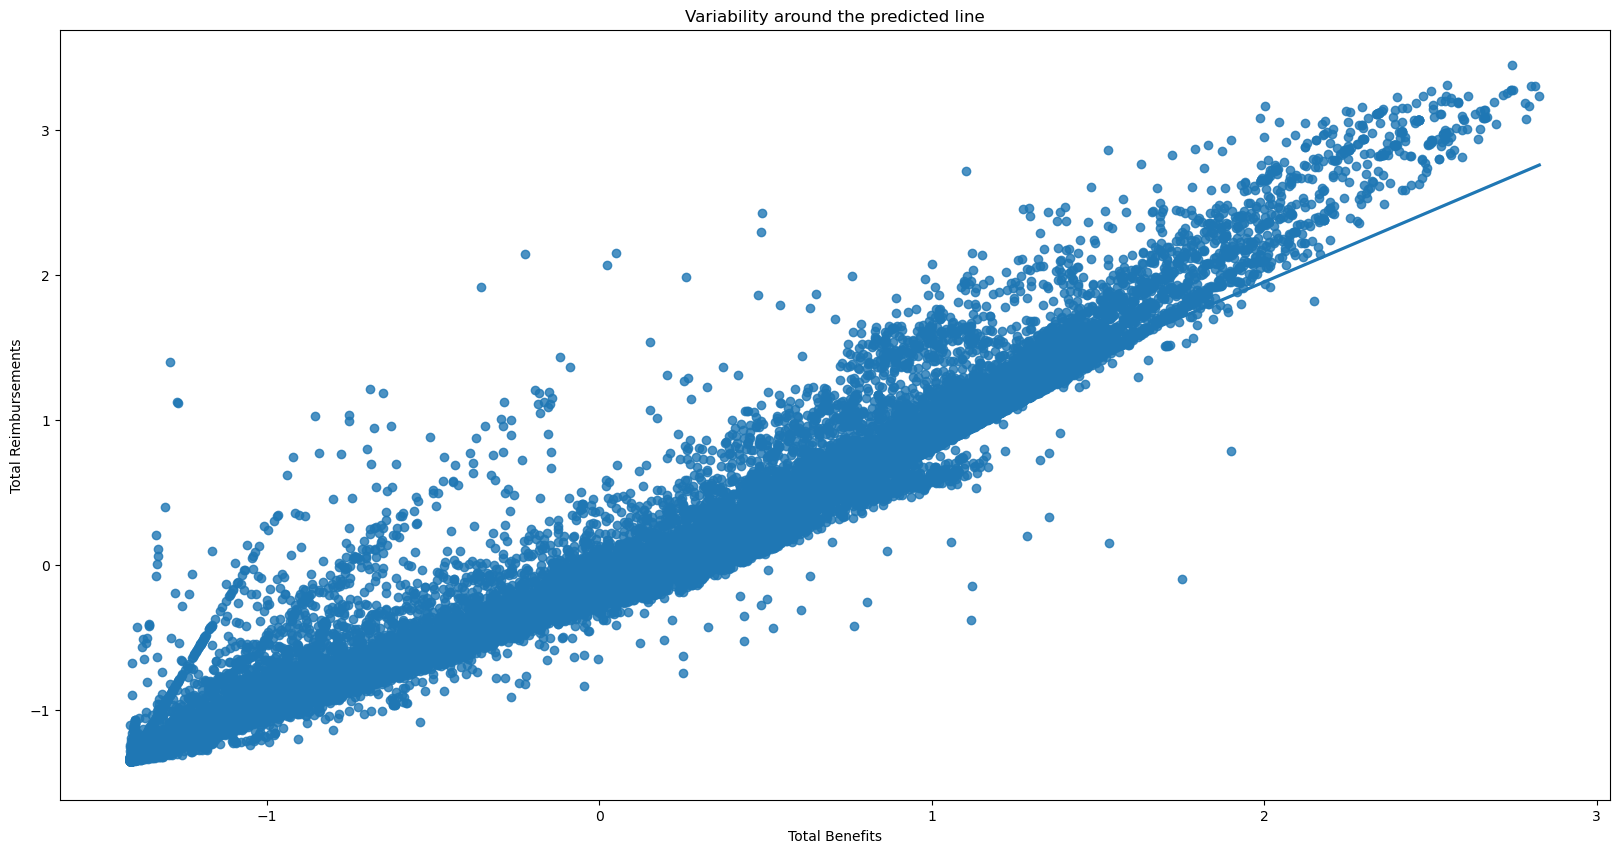

In [31]:
plt.figure(figsize = (20,10))
sns.regplot(x = x_train_slr['Total_Benefits'], y = y_train)
plt.title("Variability around the predicted line")
plt.xlabel("Total Benefits")
plt.ylabel("Total Reimbursements")
plt.show()

The blue line indicates regression line for the data. Most of the data points lie on or near the line whereas some data points are away from the line which indicates variation.

#### Coefficient of Determination (R Squared)

In [32]:
r_sq = SLR_model.rsquared
print("R-Squared",r_sq)

R-Squared 0.9485071925537295


In [33]:
# Also, R-Squared can also be calculated using SSR and SST
r_sq = ssr/sst
print("R-Squared",r_sq)

R-Squared 0.9485071925537285


Therefore, we infer that our model explains 94.85% variation in Total_Reimbursements

### Slope and Intercept

**Intercept = 1.466e-05** depcits that if Total_Benefits is 0 then Total_Reimbursements is 1.466e-05.

**Slope of Total_Benefits = 0.9744** which indicates the Total_Benefits precentage increases by 1% then Total_Reimbursements increases by 0.9744

**Total_Reimbursements = 1.466e-05 + 0.9744 * (Total_Benefits)**

### T-Test for Slope and Intercept

The coefficient of regression captures the linear relationship between independent and dependent variables. If coefficient is zero we can infer that there is no linear relationship between the two variables which is statistically important.

Formula: t_value = coefficient / standard_error
    
The test hypothesis for the t-test is given as :

**H0: Beta1 = 0** (Not Significant)

**H1: Beta1 <> 0** (Significant)

In [34]:
# params returns value of intercept and slope
# base returns the standard error of intercept and slope

In [35]:
# Standard error = Standard deviation / square root(n)

In [36]:
t_intercept = SLR_model.params[0]/SLR_model.bse[0]
print("T-Statistic for Intercept:",t_intercept)

T-Statistic for Intercept: 0.010469086141224535


In [37]:
t_slope = SLR_model.params[1]/SLR_model.bse[1]
print("T-Statistic for Slope:",t_slope)

T-Statistic for Slope: 696.2632455780571


In [38]:
n = len(x_train_slr)

# P-value for intercept
pval_intercept = stats.t.sf(np.abs(t_intercept),n-1)*2  # n-1 because of degrees of freedom 
print("P-Value for Intercept",pval_intercept)

# P-Value for Slope
pval_slope = stats.t.sf(np.abs(t_slope),n-1)*2
print("P-Value for Slope",pval_slope)

P-Value for Intercept 0.9916471097348004
P-Value for Slope 0.0


From the above p-values, we can say slope has p-value less than 0.05 which depicts that Total_Benefits is a significant independent variable whereas intercept is not.

### Confidence Interval for Slope and Intercept

In [39]:
# df = n-1 degrees of freedom
# loc = intercept coefficient to the parameter
# scale = standard error of the intercept
interval_intercept = stats.t.interval(0.95, df = df.shape[0]-1, loc = SLR_model.params[0], scale = SLR_model.bse[0])
print("95% Confidence Interval",interval_intercept)

95% Confidence Interval (-0.002729982302994635, 0.0027593022001209206)


In [40]:
interval_slope = stats.t.interval(0.95, df = df.shape[0]-1, loc = SLR_model.params[1], scale = SLR_model.bse[1])
print("95% Confidence Interval",interval_slope)

95% Confidence Interval (0.9717016395835633, 0.9771878924926883)


#### ANOVA for SLR

Analysis of Variance is used to test the significance of the linear regression. The test of hypothesis for ANOVA is given as:
    
    H0: Beta1 = 0 (i.e.regression model is not significant)
    
    H1: Beta1 <> 0 (i.e. regression model is significant)

In [41]:
slr_ols = ols(formula = "Total_Reimbursement ~ Total_Benefits", data = pd.concat([x_train_slr,y_train], axis = 1)).fit()

In [42]:
anova_slr = anova_lm(slr_ols)
anova_slr

,df,sum_sq,mean_sq,F,PR(>F)
Total_Benefits,1.0,25019.532798,25019.532798,484782.507143,0.0
Residual,26318.0,1358.266964,0.051610,NaN,NaN


As p-value is less than 0.05 for the independent variable, we reject the null hypothesis, therefore we can conclude that the regression model is significant.